# 價值股選股

* 本益比 <15
* PB < 2
* 殖利率 > 4
* 成交量 > 50%股
* C > 60MA > 120MA
* EPS 季成長
* 營收 > 前年營收

In [124]:
# initail
import pymongo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from tqdm import tqdm
import talib
import gc
from typing import Union

client = pymongo.MongoClient()
db = client['Fields']
db1 = client['Index']

In [125]:
class Chast:

    def __init__(self, client, db_name='Fields'):
        self.client = client
        self.db = client[db_name]
        self._config()
        self.data = dict()
        self.results = dict()
        self.initial_capital = 100000000
        
    def _config(self):
        # 設定繪圖、TQDM讀取條、小數點位數、顯示視窗長度
        pd.options.plotting.backend = "matplotlib"
        tqdm.pandas(desc="progress-bar")
        plt.rcParams['font.family'] = ['Microsoft JhengHei'] # 中文標籤
        plt.rcParams['axes.unicode_minus'] = False # 負號
        pd.set_option('display.max_rows', 200)
        pd.set_option('display.float_format', lambda x: '%.3f' % x)
        pd.options.display.float_format = '{:,.4f}'.format

    def _result(self):
        pf = self.results['PROFIT']
        com = self.results['COMMISION']
        self.results['RESULT'] = (pf - com).sum(axis=1).cumsum()

    def _maxdrawdown(self):
        se = self.results['RESULT']
        mdd = 0
        mdd_ = list()
        h = 0
        for i in se:
            if i > h:
                h = i
            mdd = i - h
            mdd_.append(mdd)
        self.results['MDD'] = pd.Series(mdd_, index=se.index, name='MDD')

    def _sharpe_ratio(self, roll: int = 120):
        """
        計算Sharpe ratio
        預設roll 120天=半年
        roll
        """
        pf = self.results['RESULT']
        self.results['SHARPE RATIO'] = (pf-pf.shift(1)).rolling(roll).apply(lambda x: x.mean() / x.std() if x.std() != 0 else 0, raw=True)
    
    def _holding(self):

        bs = self.results['BS']
        if '收盤價' in self.data.keys():
            holding = bs.fillna(0) * self.data['收盤價'].loc[bs.index, bs.columns] * 1000
        else:
            self.get_from_mongo('收盤價')
            holding = bs.fillna(0) * self.data['收盤價'].loc[bs.index, bs.columns] * 1000
        self.results['HOLDING'] = holding

    def _capital(self):
        self.results['CAPITAL NET'] = self.results['CAPITAL'][:-1]


    def get_chart(self):
        keys = self.results

        self._result()
        self._maxdrawdown()
        self._holding()
        self._sharpe_ratio(120)
        self._capital()

        fig ,ax = plt.subplots(6, 1, figsize=(16, 16), gridspec_kw={'height_ratios': [2, 1, 1, 1, 1, 1]})
        
        if 'RESULT' in keys:
            ax[0].plot(self.results['RESULT'][:-1])
            ax[0].set_title(f'累計損益')
            ax[0].grid(True)
            ax[0].yaxis.set_major_formatter('{x:,.0f}')
            ax[0].xaxis.set_minor_locator(mdates.YearLocator())
        if 'MDD' in keys:
            ax[1].plot(self.results['MDD'][:-1], color='orange')
            ax[1].grid(True)
            ax[1].set_title('MaxDrawdown')
            ax[1].yaxis.set_major_formatter('{x:,.0f}')
        if 'BS' in keys:
            ax[2].plot(self.results['BS'].fillna(0).astype(bool).sum(axis=1)[:-1], color='green')
            ax[2].set_title('累計股數')
        if 'HOLDING' in keys:
            ax[3].plot(self.results['HOLDING'].sum(axis=1)[:-1], color='lightgreen')
            ax[3].set_title('累計市值')
            ax[3].yaxis.set_major_formatter('{x:,.0f}')
        if 'SHARPE RATIO' in keys:
            ax[4].plot(self.results['SHARPE RATIO'][:-1], color='lightblue')
            ax[4].grid(True)
            ax[4].set_title('Rolling Sharpe Ratio')
            ax[4].yaxis.set_major_formatter('{x:.3f}')
        if 'CAPITAL' in keys:
            ax[5].plot(self.results['CAPITAL NET'][:-1], color='darkgreen')
            ax[5].grid(True)
            ax[5].set_title('Capital')
            ax[5].yaxis.set_major_formatter('{x:,.0f}')

        fig.tight_layout()
        plt.show()        

    def get_from_mongo(self, elements,
     start: Union[datetime.datetime, None]=None, 
     end: Union[datetime.datetime, None]=None):
        """
        elements: Element, 表示要在Mongo中抓哪些資料, 可用list包起來好幾項
        start: 開始時間
        end: 結束時間
        """
        
        if type(elements) != list:
            self.data[elements] = self.db[elements].find({"日期": {'$gt': start, '$lt': end}}, {'_id': 0}).set_index('日期')
        else:
            for e in elements:
                self.data[e] = self.db[e].find({"日期": {'$gt': start, '$lt': end}}, {'_id': 0}).set_index('日期')

    def set_data(self, name: str, df: pd.DataFrame):
        """
        name: 指定data名稱
        data: 放入data
        """
        self.data[name] = df
    
    def set_result(self, pf: pd.DataFrame, bs: pd.DataFrame, com: pd.DataFrame, ep: pd.DataFrame, ed: pd.DataFrame, ca: pd.Series):
        """
        pf: 損益明細
        bs: 部位明細
        com: 費用明細
        ep: 進場價格明細
        ed: 進場時間明細
        ca: 剩餘資金變化
        """
        self.results['PROFIT'] = pf
        self.results['BS'] = bs
        self.results['COMMISION'] = com
        self.results['ENTRY PRICE'] = ep
        self.results['ENTRY DATE'] = ed
        self.results['CAPITAL'] = ca

In [148]:
# Load Data
chast = Chast(client, 'Fields')
# TODO: 這邊更改成近四季試試
PE = pd.DataFrame(db['本益比(近四季)'].find({}, {'_id': 0})).set_index('日期')
PB = pd.DataFrame(db['股價淨值比'].find({}, {'_id': 0})).set_index('日期')
收盤價 = pd.DataFrame(db['還原收盤價'].find({}, {'_id': 0})).set_index('日期')
成交金額 = pd.DataFrame(db['成交金額(千)'].find({}, {'_id': 0})).set_index('日期')
MA60 = 收盤價.rolling(60).mean()
MA120 = 收盤價.rolling(120).mean()
大盤收盤價 = pd.DataFrame(db1['TWA00'].find({}, {'_id': 0, '日期': 1, '還原收盤價': 1})).set_index('日期').dropna(how='all')
log收盤價 = 收盤價.copy()
for c in log收盤價.columns:
    if log收盤價.loc[:, c].sum() != 0:
        log收盤價.loc[:, c] = np.log(log收盤價.loc[:, c])

殖利率 = pd.DataFrame(db['殖利率'].find({}, {'_id': 0})).set_index('日期')
EPS = pd.DataFrame(db['EPS_Q'].find({}, {'_id': 0})).set_index('日期')
預估EPS = pd.DataFrame(db['預估EPS_Q'].find({}, {'_id': 0})).set_index('日期')
營業收入淨額 = pd.DataFrame(db['營業收入淨額_Q'].find({}, {'_id': 0})).set_index('日期')

c:\Users\ChastLai\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ChastLai\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ChastLai\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ChastLai\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ChastLai\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ChastLai\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zer

In [150]:
def creat_to_daily(df: pd.DataFrame):
    n = pd.DataFrame(columns=PE.columns, index=PE.index.union(df.index))
    for i in df.index:
        for c in df.columns:
            n.at[i, str(c)] = df.at[i, c]
    return n.fillna(method='ffill')

殖利率 = 殖利率.loc[PE.index.intersection(殖利率.index)]
# TODO: EPS則改成四季累積的差，避免淡旺季差異
EPS = EPS.rolling(4).sum().pct_change().loc[PE.index[0]:].replace([np.inf, -np.inf], np.nan)
預估EPS = 預估EPS.rolling(4).sum().pct_change(4).loc[PE.index[0]:].replace([np.inf, -np.inf], np.nan)
營業收入淨額 = 營業收入淨額.pct_change().loc[PE.index[0]:].replace([np.inf, -np.inf], np.nan)

EPS_n = creat_to_daily(EPS).loc[PE.index]
預估EPS_n = creat_to_daily(預估EPS).loc[PE.index]
營業收入淨額_n = creat_to_daily(營業收入淨額).loc[PE.index]
殖利率.columns = 殖利率.columns.astype(str)
殖利率 = 殖利率.loc[PE.index]

In [151]:
buy = (PE < 15)&\
    (PB < 1.5)&\
    (成交金額.ge(成交金額.median(axis=1), axis=0))&\
    (收盤價 > MA60)&\
    (收盤價 > MA120)&\
    (EPS_n > 0)&\
    (營業收入淨額_n > 0)&\
    (殖利率 > 4)
buy = buy.shift(1)

In [169]:
buy = (PE.lt(PE.quantile(.28, axis=1), axis=0))&\
    (PB.lt(PB.quantile(.28, axis=1), axis=0))&\
    (成交金額.gt(成交金額.median(axis=1), axis=0))&\
    (收盤價 > MA60)&\
    (收盤價 > MA120)&\
    (EPS_n > 0)&\
    (營業收入淨額_n > 0)&\
    (殖利率.gt(殖利率.quantile(.68, axis=1), axis=0))
buy = buy.shift(1)

In [152]:
sell = (PE > 30)&\
    (PB > 3)&\
    (成交金額.ge(成交金額.median(axis=1), axis=0))&\
    (收盤價 < MA60)&\
    (收盤價 < MA120)&\
    (EPS_n < 0)&\
    (營業收入淨額_n < 0)&\
    (殖利率 < 4)
sell = sell.shift(1)

In [170]:
sell = (PE.gt(PE.quantile(.72, axis=1), axis=0))&\
    (PB.gt(PB.quantile(.72, axis=1), axis=0))&\
    (成交金額.gt(成交金額.median(axis=1), axis=0))&\
    (收盤價 < MA60)&\
    (收盤價 < MA120)&\
    (EPS_n < 0)&\
    (營業收入淨額_n < 0)&\
    (殖利率.lt(殖利率.quantile(.68, axis=1), axis=0))
sell = sell.shift(1)

In [171]:
月初 = buy.groupby(pd.Grouper(freq='m')).head(1)
月初賣 = sell.groupby(pd.Grouper(freq='m')).head(1)
月末 = buy.groupby(pd.Grouper(freq='m')).tail(1)
月末賣 = sell.groupby(pd.Grouper(freq='m')).tail(1)
股票名稱轉換 = pd.DataFrame(client['Index']['股票名稱轉換'].find({}, {'_id': 0})).to_dict('records')[0]

In [172]:
def 轉日資料處理(df: pd.DataFrame):
    轉日 = pd.DataFrame(index=收盤價.index, columns=收盤價.columns)
    for i in df.index:
        for c in df.columns:
            轉日.at[i, c] = df.at[i, c]
    轉日 = 轉日.sort_index().fillna(method='ffill')
    return 轉日


def 損益(轉日: pd.DataFrame, 買賣):
    大盤損益 = 大盤收盤價.pct_change().cumsum()
    日損益 = log收盤價.shift(-1) - log收盤價
    換股日損益 = 轉日 * 日損益 * 買賣
    進場 = 轉日 - 轉日.shift(1)
    出場 = 轉日.shift(-1) - 轉日
    費用 = 轉日.copy()
    費用.iloc[:] = 0
    費用[進場 > 0] = 0.001425
    費用[出場 < 0] = 0.004425
    換股日平均損益 = (換股日損益-費用).sum(axis=1) / 轉日.sum(axis=1)
    fig, ax = plt.subplots(figsize=(8, 5))
    ax1 = ax.twinx()
    ax.plot(換股日平均損益.fillna(0).cumsum())
    ax.plot(大盤損益)
    ax1.plot(轉日.sum(axis=1), color='green')
    ax.grid(True)
    plt.show()
    print('當前持倉: ', {v: 股票名稱轉換[v] for v in 轉日.iloc[-1][轉日.iloc[-1] >= 1].index})
    return 換股日平均損益

def 損益金額(轉日: pd.DataFrame):
    持倉金額 = (轉日 * 收盤價 * 1000).sum(axis=1)
    大盤損益 = (大盤收盤價.pct_change().mul(持倉金額, axis=0)).cumsum()
    日損益 = (收盤價.pct_change().shift(-1))
    換股日損益 = 轉日 * 日損益 * 1000
    換股日平均損益 = 換股日損益.sum(axis=1)
    fig, ax = plt.subplots(figsize=(16, 9))
    ax1 = ax.twinx()
    ax.plot(換股日平均損益.fillna(0).cumsum())
    #ax.plot(大盤損益)
    ax1.plot(轉日.sum(axis=1), color='green')
    ax.grid(True)
    plt.show()
    print('當前持倉: ', 轉日.iloc[-1][轉日.iloc[-1] >= 1].index)


轉日月末 = 轉日資料處理(月末)
轉日月末賣 = 轉日資料處理(月末賣)
日平均 = 損益(轉日月末, 1)
日賣平均 = 損益(轉日月末賣, -1)

(日平均.fillna(0) + 日賣平均.fillna(0)).cumsum().plot(figsize=(8, 5), grid=True)#.groupby(pd.Grouper(freq='1y')).sum()
print((日平均.fillna(0) + 日賣平均.fillna(0)).groupby(pd.Grouper(freq='1y')).sum())
plt.show()

In [ ]:
# 用還原收盤價當基準
收盤價 = pd.DataFrame(db['收盤價'].find({}, {'_id': 0})).set_index('日期')
還原收盤價 = pd.DataFrame(db['還原收盤價'].find({}, {'_id': 0})).set_index('日期')

In [118]:
def backtesting(per_capital: int = 250000, total_capital: int = 100000000):
    f_idx, f_col = 收盤價.index, 收盤價.columns
    # 製作空表格，用於計算時存值，最後set回去五個底線dataframe
    def make_df(idx, col):
        return pd.DataFrame(index=idx, columns=col)

    bs = make_df(f_idx, f_col).fillna(0)
    com_ = make_df(f_idx, f_col).fillna(0)
    pf_ = make_df(f_idx, f_col).fillna(0)
    ep_ = make_df(f_idx, f_col).fillna(99999)
    ed_ = make_df(f_idx, f_col).fillna(f_idx[0])
    bs_ = make_df(f_idx, f_col).fillna(0)
    eh_ = make_df(f_idx, f_col).fillna(0)

    # 存前一根K的時間
    idx1 = f_idx[0]
    # 還原收盤價與收盤價的轉換
    transform = 收盤價 / 還原收盤價
    # 資金設定 1 億
    # per_capital = 250000
    # total_capital = 100000000
    capital = pd.Series([total_capital] * len(f_idx), index=f_idx)

    ## ----------------------------------------------------------------------------------------------------------------------------------------##
    for idx, row in 還原收盤價.iterrows():
        # 用at取代loc，聽說更快
        for col in row.index:
            bs_.at[idx, col] = bs.at[idx1, col]
            bs.at[idx, col] = bs.at[idx1, col]
            ep_.at[idx, col] = ep_.at[idx1, col]
            eh_.at[idx, col] = eh_.at[idx1, col]
            ed_.at[idx, col] = ed_.at[idx1, col]

        capital[idx] = capital[idx1]
        
        # 進場條件1
        entry_mask1 = (bs.loc[idx, :] == 0) & buy.loc[idx, :]
        
        # 出場條件
        exit_mask = (bs_.loc[idx, :] >= 1) & (buy.loc[idx, :] == False)
        # | \ 
        #    ((chast.data['還原收盤價'].loc[idx, :] > ep_.loc[idx, :] * 1.5) | \
        #    (chast.data['還原收盤價'].loc[idx, :] < eh_.loc[idx, :] * 0.9))
        # 當有商品滿足進場條件時執行  
        if entry_mask1.sum() > 0:
            # 用Sharpe Ratio排序股票，作為買進順序
            for col in PB.loc[idx, row[entry_mask1].index].rank(ascending=True).sort_values().index:
                # 買進的股數
                contract = np.floor(per_capital / 收盤價.at[idx, col] / 1000)
                # 買進花多少錢
                money = contract * 1000 * 收盤價.at[idx, col]
                # 目前持倉多少錢
                holding = ((收盤價.loc[idx, :] * bs.loc[idx, :]) * 1000).sum()
                # 若資金足夠、持倉市值沒太大才買進
                if (capital.at[idx] > money) & (holding < total_capital) & (contract >= 1):
                    bs.at[idx, col] = contract
                    capital.at[idx] -= money
                else:
                    pass
                
        # 當有商品滿足出場條件時執行
        if exit_mask.sum() > 0:
            for col in row[exit_mask].index:
                money = bs.at[idx, col] * 1000 * 收盤價.at[idx, col]
                capital.at[idx] += money
                bs.at[idx, col] = 0
                
        for col in row.index:
            # 進場
            if (bs_.at[idx, col] >= 1) & (bs_.at[idx1, col] == 0):
                com_.at[idx, col] = np.round((0.001425 + 0.003) * bs_.at[idx, col] * 1000 * 收盤價.at[idx, col], 2)
                ep_.at[idx, col] = 還原收盤價.at[idx, col]
                eh_.at[idx, col] = 還原收盤價.at[idx, col]
                ed_.at[idx, col] = idx
            # 出場   
            if (bs_.at[idx, col] == 0) & (bs_.at[idx1, col] >= 1):
                com_.at[idx, col] = np.round((0.001425 + 0.003 +0.003) * bs_.at[idx1, col] * 1000 * 收盤價.at[idx, col], 2)
                # money = np.round(bs_.at[idx1, col] * 1000 * chast.data['收盤價'].at[idx, col], 2)
                # capital.at[idx] += money
                # print(f'出場 capital 剩餘: {capital.at[idx]} 增加資金: {money}')
            
            # 損益計算
            if (bs_.at[idx1, col] >= 1):
                pf_.at[idx, col] = np.round((還原收盤價.at[idx, col] - 還原收盤價.at[idx1, col]) * transform.at[idx1, col] * bs_.at[idx1, col] * 1000, 2)
                if 還原收盤價.at[idx, col] > eh_.at[idx, col]:
                    eh_.at[idx, col] = 還原收盤價.at[idx, col]
        
        idx1 = idx
    ## ----------------------------------------------------------------------------------------------------------------------------------------##
    chast.set_result(pf_, bs_, com_, ep_, ed_, capital)
    chast.get_chart()



日期
2000-12-31    0.0000
2001-12-31    0.0000
2002-12-31    0.0000
2003-12-31    0.0000
2004-12-31    0.0000
2005-12-31    0.4463
2006-12-31    0.0963
2007-12-31    1.0690
2008-12-31    0.5479
2009-12-31    0.5199
2010-12-31    0.2293
2011-12-31    0.2747
2012-12-31    0.0417
2013-12-31    0.4018
2014-12-31    0.2749
2015-12-31    0.3591
2016-12-31    0.0446
2017-12-31    0.1731
2018-12-31    0.3172
2019-12-31    0.1742
2020-12-31    0.5532
2021-12-31   -0.1941
2022-12-31    0.2262
Freq: A-DEC, dtype: float64

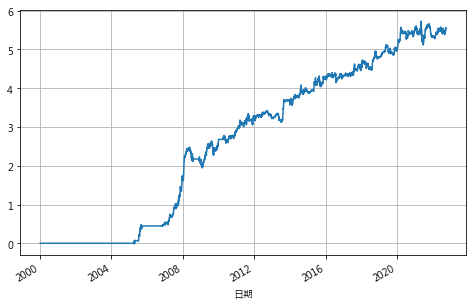

In [156]:
(日平均.fillna(0) + 日賣平均.fillna(0)).cumsum().plot(figsize=(8, 5), grid=True)#.groupby(pd.Grouper(freq='1y')).sum()
(日平均.fillna(0) + 日賣平均.fillna(0)).groupby(pd.Grouper(freq='1y')).sum()

In [119]:
backtesting()

TypeError: get_from_mongo() missing 2 required positional arguments: 'start' and 'end'

<AxesSubplot:xlabel='日期'>

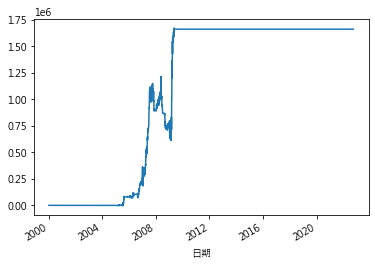

In [123]:
chast.results['PROFIT'].sum(axis=1).cumsum().plot()